importing Jupyter notebook from model_test.ipynb
hate_data : 100000
genderbias_data : 1232
ilbe_data : 2044
등장 빈도가 1번 이하인 희귀 단어의 수: 23480
단어 집합(vocabulary)에서 희귀 단어의 비율: 83.15625442697267
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 48.27699646352496
문장 최대 길이 : 194
문장 평균 길이 : 9.374711


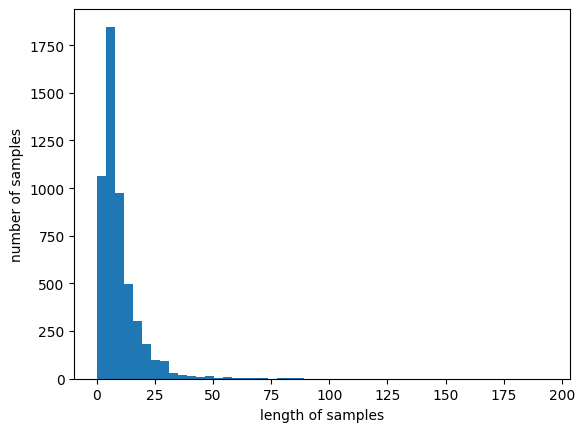

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 194, 64)           64000000  
                                                                 
 dropout (Dropout)           (None, 194, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 192, 64)           12352     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

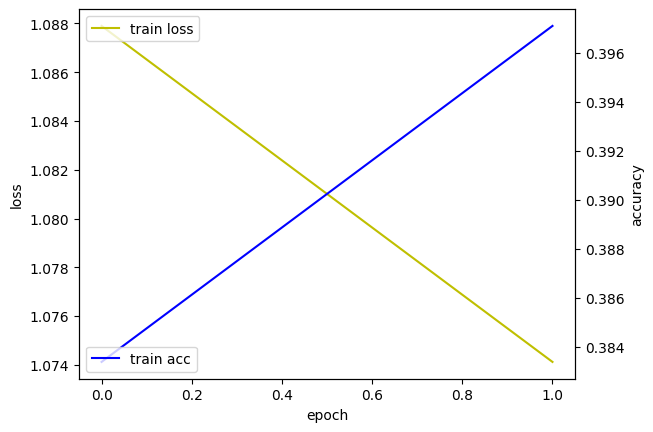

33/33 [==============================] - 0s 4ms/step - loss: 1.0667 - accuracy: 0.4277
테스트 정확도: 0.4277
Model Saved


In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import import_ipynb
import model_test_for_openmax_revise

In [2]:
input_data = str(input())   # 아직 입력부를 구현하지 않아 임시로 입력

In [3]:
def tokenize(x_data, tokenizer):
    tokenizer.fit_on_texts(x_data) # 데이터의 각 행별로 토큰화 수행
    return tokenizer.texts_to_sequences(x_data)    

In [4]:
x_data = []
x_data.append(input_data)
y_data = -1    # 임시 값

x_data

['안녕하세요 저는 김건형입니다']

In [5]:
tokenizer = Tokenizer()
sequences = tokenize(x_data, tokenizer)
sequences

[[1, 2, 3]]

## 모델 적용

In [6]:
from keras.models import model_from_json
json_file = open("model.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [7]:
loaded_model.load_weights("model_weight.h5")

In [8]:
#model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True),metrics= ["accuracy"])
#es = EarlyStopping(monitor='loss', mode='min' , min_delta=0)
#check_point = ModelCheckpoint('apply_model.h5', monitor='loss', mode='min', save_best_only=True)
loaded_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics= ["accuracy"])

In [10]:
data = sequences
X_data = pad_sequences(data, maxlen = model_test_for_openmax_revise.pad_size)
X_result = model_test_for_openmax_revise.model.predict(X_data, batch_size=32)
X_Softmax = model_test_for_openmax_revise.model2.predict(X_result)

X_result = X_result[0]
X_result

AttributeError: module 'model_test' has no attribute 'pad_size'

## logit Vector, Distance 계산

## 모델 저장

In [297]:
dist0 = model_test_for_openmax_revise.distance(model_test_for_openmax_revise.average_0, X_result)
dist1 = model_test_for_openmax_revise.distance(model_test_for_openmax_revise.average_1, X_result)
dist2 = model_test_for_openmax_revise.distance(model_test_for_openmax_revise.average_2, X_result)

## CDF 계산

In [312]:
import scipy.stats as s
import matplotlib.pyplot as plt

In [313]:
def calculCDF(dist):
    CDF = s.exponweib.cdf(i, *s.exponweib.fit(i, 1, 1, scale=2, loc=0))     
    return CDF

def weib(x,n,a):
    return (a / n) * (x / n)**(a - 1) * np.exp(-(x / n)**a)

CDF0 = weib(dist0, model_test_for_openmax_revise.loc0, model_test_for_openmax_revise.scale0)
CDF1 = weib(dist1, model_test_for_openmax_revise.loc1, model_test_for_openmax_revise.scale1)
CDF2 = calculCDF(dist2)

CDF0

AttributeError: module 'model_test_for_openmax_revise' has no attribute 'loc0'

## Logit Vector 업데이트

In [306]:
updated_logit = []

logit0 = X_result[0]-(X_result[0]*CDF0)
logit1 = X_result[1]-(X_result[1]*CDF1)
logit2 = X_result[2]-(X_result[2]*CDF2)
unknown_logit = CDF0*X_result[0] + CDF1*X_result[1] + CDF2*X_result[2]    # unknown class의 logit vector     

updated_logit = [unknown_logit, logit0, logit1, logit2]

updated_logit

[-0.020461654635741358,
 10.331934406077647,
 -3.7430432357105405,
 -9.986901328933268]

## Softmax Layer 통과

In [301]:
# softmax function
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [302]:
result_arr = softmax(updated_logit)
arr = result_arr.tolist()
arr

[3.1915181593394925e-05,
 0.9999673118826238,
 7.714373835148223e-07,
 1.4983993124385063e-09]

## 결과 확인

In [303]:
res = arr.index(max(arr))
res

1

In [304]:
if(res==0):
    resultstr = "Unknown"
elif(res==1):
    resultstr = "혐오성 댓글"
elif(res==2):
    resultstr = "일베 댓글"
elif(res == 3):
    resultstr = "여성 비하성 댓글"
    
resultstr

'혐오성 댓글'

In [305]:
print(str(arr[res]) + " 확률로 " + resultstr +"입니다.")

0.9999673118826238 확률로 혐오성 댓글입니다.
